In [ ]:
#configuring the path of kaggle file .json type
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d uciml/sms-spam-collection-dataset

100% 211k/211k [00:00<00:00, 409kB/s]
100% 211k/211k [00:00<00:00, 408kB/s]


In [ ]:
# extracting the dataset from its compressed format
from zipfile import ZipFile
dataset='/content/sms-spam-collection-dataset.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print("The dataset is extracted")

The dataset is extracted


In [ ]:
!pip install tensorflow_text

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
import pandas as pd
# Read the CSV file
data = pd.read_csv('/content/spam.csv',encoding='latin1')
# Rename the columns
data = data.rename(columns={'v1': 'Category', 'v2': 'Message'})
# Drop the unwanted columns
data = data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
# Display the updated DataFrame
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
data.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [ ]:
data['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [ ]:
dataSpam=data[data['Category']=='spam']
print("Spam : ",dataSpam.shape)
dataHam=data[data['Category']=='ham']
print("Ham : ",dataHam.shape)

Spam :  (747, 2)
Ham :  (4825, 2)


In [ ]:
dataHamDownSamp=dataHam.sample(dataSpam.shape[0])
dataHamDownSamp.shape

(747, 2)

In [ ]:
dataBalance=pd.concat([dataSpam,dataHamDownSamp])
dataBalance.shape

(1494, 2)

In [ ]:
dataBalance['Category'].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [ ]:
dataBalance['spam']=dataBalance['Category'].apply(lambda x: 1 if x=='spam' else 0)
dataBalance.sample(8)

,Category,Message,spam
1720,ham,"Fighting with the world is easy, u either win ...",0
1852,spam,This is the 2nd time we have tried 2 contact u...,1
4637,ham,Captain vijaykanth is doing comedy in captain ...,0
2398,ham,YO YO YO BYATCH WHASSUP?,0
1746,ham,I don know account details..i will ask my mom ...,0
4525,spam,"I want some cock! My hubby's away, I need a re...",1
2773,spam,How come it takes so little time for a child w...,1
3895,spam,tells u 2 call 09066358152 to claim å£5000 pri...,1


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(dataBalance['Message'],dataBalance['spam'],stratify=dataBalance['spam'],test_size=0.2, random_state=42)

In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1195,)
Shape of X_test: (299,)
Shape of y_train: (1195,)
Shape of y_test: (299,)


In [35]:
X_train.head(5)

1224    You are a winner U have been specially selecte...
4951    Welcome to Select, an O2 service with added be...
3699           Oh...i asked for fun. Haha...take care. Ì_
2144    FreeMsg: Hey - I'm Buffy. 25 and love to satis...
4084    Orange brings you ringtones from all time Char...
Name: Message, dtype: object

In [36]:
preprocess_url='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
encoder_url='https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

In [40]:
bert_preprocess=hub.KerasLayer(preprocess_url)
bert_encoder=hub.KerasLayer(encoder_url)

def getSentenceEmbed(sentences):
  textPreprocessed=bert_preprocess(sentences)
  return bert_encoder(textPreprocessed)['pooled_output']

getSentenceEmbed(["500$ discount, hurry up","let's go watch that movie","suzume was not so good"])

<tf.Tensor: shape=(3, 768), dtype=float32, numpy=
array([[-0.7734204 , -0.5013771 , -0.80737484, ..., -0.6057659 ,
        -0.7409629 ,  0.8849831 ],
       [-0.9268777 , -0.4301714 , -0.5814137 , ..., -0.35385072,
        -0.71531266,  0.9394445 ],
       [-0.69711375, -0.28548202,  0.27764827, ...,  0.2505527 ,
        -0.5802779 ,  0.82650894]], dtype=float32)>

In [43]:
e=getSentenceEmbed([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"])

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911088]], dtype=float32)

Values near to 1 means they are similar. 0 means they are very different. Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

In [45]:
cosine_similarity([e[0]],[e[3]])

array([[0.84703803]], dtype=float32)

Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

In [46]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872035]], dtype=float32)

Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

In [47]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [48]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [49]:
len(X_train)

1195

In [50]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [52]:
model.fit(X_train, y_train, epochs=25)

Epoch 1/25
38/38 [==============================] - 13s 331ms/step - loss: 0.2607 - accuracy: 0.9197 - precision: 0.9048 - recall: 0.9381
Epoch 2/25
38/38 [==============================] - 13s 336ms/step - loss: 0.2539 - accuracy: 0.9255 - precision: 0.9207 - recall: 0.9314
Epoch 3/25
38/38 [==============================] - 13s 338ms/step - loss: 0.2578 - accuracy: 0.9146 - precision: 0.9147 - recall: 0.9147
Epoch 4/25
38/38 [==============================] - 13s 337ms/step - loss: 0.2489 - accuracy: 0.9163 - precision: 0.9003 - recall: 0.9365
Epoch 5/25
38/38 [==============================] - 13s 334ms/step - loss: 0.2394 - accuracy: 0.9247 - precision: 0.9150 - recall: 0.9365
Epoch 6/25
38/38 [==============================] - 13s 331ms/step - loss: 0.2248 - accuracy: 0.9264 - precision: 0.9250 - recall: 0.9281
Epoch 7/25
38/38 [==============================] - 13s 332ms/step - loss: 0.2300 - accuracy: 0.9222 - precision: 0.9119 - recall: 0.9348
Epoch 8/25
38/38 [================

In [53]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 4s 315ms/step - loss: 0.1682 - accuracy: 0.9498 - precision: 0.9351 - recall: 0.9664


[0.16816547513008118,
 0.9498327970504761,
 0.9350649118423462,
 0.9664429426193237]

In [54]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

10/10 [==============================] - 4s 325ms/step


In [55]:
import numpy as np
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0])

In [56]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_predicted)
cm 

array([[140,  10],
       [  5, 144]])

Text(50.722222222222214, 0.5, 'Truth')

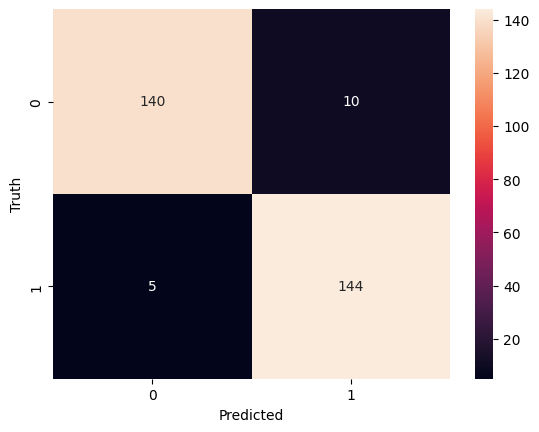

In [57]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [58]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       150
           1       0.94      0.97      0.95       149

    accuracy                           0.95       299
   macro avg       0.95      0.95      0.95       299
weighted avg       0.95      0.95      0.95       299



Lets Predict

In [59]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

1/1 [==============================] - 1s 764ms/step


array([[0.8985616 ],
       [0.96102947],
       [0.822498  ],
       [0.15124111],
       [0.03523459]], dtype=float32)

Higher the percentage, higher is the chance of the message being a spam

In [61]:
reviews = [ 'Congratulations! You have won a luxury vacation for two. Claim your prize now!',
    'Reminder: Parent-teacher meeting tomorrow at 5 PM. Please make sure to attend.',
    'Limited time offer: Buy one, get one free on all clothing items. Visit our store today!',
    'Dear customer, your order has been successfully delivered. We hope you enjoy your purchase.',
    'URGENT: Your account has been locked due to suspicious activity. Click the link to verify your information.',
    'Just a friendly reminder to pay your monthly utility bill by the due date to avoid any late fees.'
          ]
model.predict(reviews)

1/1 [==============================] - 0s 52ms/step


array([[0.37180236],
       [0.35683152],
       [0.8897648 ],
       [0.19411561],
       [0.7228263 ],
       [0.23731214]], dtype=float32)